# Redshift Database Tutorial

## Abstract

This tutorial will cover the basics of using the redshift database, which is loaded from the outputs of the DESI pipeline.  Currently, this is based on reference run 19.2, and uses a SQLite database.  However, by using [SQLAlchemy](http://www.sqlalchemy.org/), we abstract away the details of the database.  In other words only tiny changes to the initial configuration are needed to run the same code with a [PostgreSQL](https://www.postgresql.org/) database.

## Requirements

This tutorial uses data from the 19.12 reference run (`/global/cfs/cdirs/desi/datachallenge/reference_runs/19.12`), and the **DESI 22.2** kernel.

## Initial Setup

This just imports everything we need and sets up paths and environment variables so we can find things.  The paths are based on the [minitest notebook](https://github.com/desihub/desitest/blob/master/mini/minitest.ipynb).

In [1]:
#
# Imports
#
import os
from argparse import Namespace
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from sqlalchemy import __version__ as sqlalchemy_version
from sqlalchemy import inspect
from sqlalchemy.sql import func
from astropy.constants import c as lightspeed
from astropy.table import Table, MaskedColumn
#
# DESI software
#
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)
from desisim.spec_qa import redshifts as dsq_z
from desispec import __version__ as desispec_version
import desispec.database.redshift as db
#
# Paths to files, etc.
#
reference_run = '19.12'
program = 'dark'
basedir = os.path.join(os.environ['DESI_ROOT'], 'datachallenge', 'reference_runs', reference_run)
surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'
reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir
#
# Working directory.
#
workingdir = os.getcwd()
print(desispec_version)

0.51.13


## Loading the Database

### Introduction

Although there is normally already a database loaded from the reference_run results, we'll still go through the exercise of loading a new database directly from the files.  It should take less than one minute to load.

If you've *already* loaded the database, skip the cell immediately below and jump to the cell with the comment "If the database already exists...".

The files that get loaded are:

* `survey/exposures.fits`.  This records the data about individual exposures.
  - Database table name: `obslist`.
  - SQLAlchemy object: `db.ObsList`.
  - Primary key: `expid`.
* `targets/truth.fits`.  The truth table.  What is the *true* redshift of this object?
  - Database table name: `truth`.
  - SQLAlchemy object: `db.Truth`.
  - Primary key: `targetid`.
* `targets/target.fits`. The target table.  What objects are we *trying* to observe?
  - Database table name: `target`.
  - SQLAlchemy object: `db.Target`.
  - Primary key: `targetid`.
* `spectro/redux/mini/zcatalog-mini.fits`. The actual redshift catalog; the results of the pipeline.
  - Database table name: `zcat`.
  - SQLAlchemy object: `db.ZCat`.
  - Primary key: `targetid`.
* `fiberassign/tile-*.fits`. The fiber assignment data.  What fiber ended up on what target?
  - Database table name: `fiberassign`.
  - SQLAlchemy object: `db.FiberAssign`.
  - Primary key: (`tileid`, `fiber`).

### Create the Empty Database

We'll be using a SQLite database, just ignore the return value of `db.setup_db()`.

In [2]:
postgresql = db.setup_db(dbfile=os.path.join(workingdir, 'minitest-{0}.db'.format(reference_run)),
                         overwrite=True)

INFO:redshift.py:821:setup_db: Removing file: /global/cscratch1/sd/forero/tutorials/minitest-19.12.db.
INFO:redshift.py:830:setup_db: Begin creating tables.
INFO:redshift.py:834:setup_db: Finished creating tables.


### The List of Exposures

The `expand` option renames the column `PASS` to `passnum` in the database.  This is to prevent any collisions with the Python statement `pass`.

Calibration exposures do not have a well-defined value of (RA, Dec), so in the file, they might be set to NaN.  The `rowfilter` option eliminates those rows, and the warning can be ignored.

In [3]:
db.load_file(os.path.join(surveydir, 'exposures.fits'), db.ObsList, hdu='EXPOSURES', expand={'PASS': 'passnum'},
             rowfilter=lambda x: (x['PROGRAM'] != 'CALIB'))

INFO:redshift.py:383:load_file: Read data from /global/cfs/cdirs/desi/datachallenge/reference_runs/19.12/survey/exposures.fits HDU EXPOSURES
INFO:redshift.py:401:load_file: Integrity check complete on obslist.
INFO:redshift.py:409:load_file: Initial column conversion complete on obslist.
INFO:redshift.py:431:load_file: Column expansion complete on obslist.
INFO:redshift.py:437:load_file: Column conversion complete on obslist.
INFO:redshift.py:444:load_file: Converted columns into rows on obslist.
INFO:redshift.py:450:load_file: Inserted 21 rows in obslist.


### The Truth and Target Tables

Note that we are only loading `program = 'dark'`.  As of release 19.12, the data model for the 'bright' truth tables appears to be different from the 'dark' data model.

In [4]:
db.load_file(os.path.join(targetdir, 'truth-{0}.fits'.format(program)), db.Truth, hdu='TRUTH')
for h in ('BGS', 'ELG', 'LRG', 'QSO', 'STAR', 'WD'):
    db.update_truth(os.path.join(targetdir, 'truth-{0}.fits'.format(program)), 'TRUTH_' + h)
# db.load_file(os.path.join(targetdir, 'truth-bright.fits'), db.Truth, hdu='TRUTH')
# for h in ('BGS', 'STAR', 'WD'):
#     db.update_truth(os.path.join(targetdir, 'truth-bright.fits'), 'TRUTH_' + h)
db.load_file(os.path.join(targetdir, 'targets-{0}.fits'.format(program)), db.Target, hdu='TARGETS',
             expand={'DCHISQ': ('dchisq_psf', 'dchisq_rex', 'dchisq_dev', 'dchisq_exp', 'dchisq_comp',)})

INFO:redshift.py:383:load_file: Read data from /global/cfs/cdirs/desi/datachallenge/reference_runs/19.12/targets/truth-dark.fits HDU TRUTH
INFO:redshift.py:401:load_file: Integrity check complete on truth.
INFO:redshift.py:409:load_file: Initial column conversion complete on truth.
INFO:redshift.py:431:load_file: Column expansion complete on truth.
INFO:redshift.py:437:load_file: Column conversion complete on truth.
INFO:redshift.py:444:load_file: Converted columns into rows on truth.
INFO:redshift.py:450:load_file: Inserted 50000 rows in truth.
INFO:redshift.py:450:load_file: Inserted 100000 rows in truth.
INFO:redshift.py:450:load_file: Inserted 150000 rows in truth.
INFO:redshift.py:450:load_file: Inserted 184540 rows in truth.
INFO:redshift.py:491:update_truth: Read data from /global/cfs/cdirs/desi/datachallenge/reference_runs/19.12/targets/truth-dark.fits HDU TRUTH_BGS
INFO:redshift.py:503:update_truth: Integrity check complete on truth.
INFO:redshift.py:513:update_truth: Initial 

### The Redshift Catalog

In this case the expand option expands an array-valued column into corresponding scalar database columns.
We also need to filter out some (simulated!) bad fibers that don't have a valid TARGETID (as of reference run 19.2 there are no such columns).

In [5]:
db.load_file(os.path.join(reduxdir, 'zcatalog-mini.fits'), db.ZCat, hdu="ZCATALOG",
             expand={'COEFF': ('coeff_0', 'coeff_1', 'coeff_2', 'coeff_3', 'coeff_4',
                               'coeff_5', 'coeff_6', 'coeff_7', 'coeff_8', 'coeff_9',)},
             rowfilter=lambda x: ((x['TARGETID'] != 0) & (x['TARGETID'] != -1)))

INFO:redshift.py:383:load_file: Read data from /global/cfs/cdirs/desi/datachallenge/reference_runs/19.12/spectro/redux/mini/zcatalog-mini.fits HDU ZCATALOG
INFO:redshift.py:401:load_file: Integrity check complete on zcat.
INFO:redshift.py:409:load_file: Initial column conversion complete on zcat.
INFO:redshift.py:431:load_file: Column expansion complete on zcat.
INFO:redshift.py:437:load_file: Column conversion complete on zcat.
INFO:redshift.py:444:load_file: Converted columns into rows on zcat.
INFO:redshift.py:450:load_file: Inserted 46156 rows in zcat.


### Fiberassign Outputs

The fiberassign outputs are not contained in a single file so a special loading function is needed.

In [6]:
db.load_fiberassign(fibassigndir)

INFO:redshift.py:640:load_fiberassign: Using tile file search path: /global/cfs/cdirs/desi/datachallenge/reference_runs/19.12/fiberassign/fiberassign*.fits*.
INFO:redshift.py:645:load_fiberassign: Found 10 tile files.
INFO:redshift.py:669:load_fiberassign: Identified 10 tile files for loading.
INFO:redshift.py:678:load_fiberassign: Read data from /global/cfs/cdirs/desi/datachallenge/reference_runs/19.12/fiberassign/fiberassign-034170.fits HDU FIBERASSIGN
INFO:redshift.py:699:load_fiberassign: Initial column conversion complete on tileid = 34170.
INFO:redshift.py:701:load_fiberassign: Converted columns into rows on tileid = 34170.
INFO:redshift.py:704:load_fiberassign: Inserted 5000 rows in fiberassign for tileid = 34170.
INFO:redshift.py:678:load_fiberassign: Read data from /global/cfs/cdirs/desi/datachallenge/reference_runs/19.12/fiberassign/fiberassign-006927.fits HDU FIBERASSIGN
INFO:redshift.py:699:load_fiberassign: Initial column conversion complete on tileid = 6927.
INFO:redshift

### Database Already Exists?

If the database already exists, just skip to this step.

In [7]:
postgresql = db.setup_db(dbfile=os.path.join(workingdir, 'minitest-{0}.db'.format(reference_run)))

INFO:redshift.py:830:setup_db: Begin creating tables.
INFO:redshift.py:834:setup_db: Finished creating tables.


## Learning About the Tables

The tables in the database are listed above.  To inspect an individual table, you can use the `__table__` attribute.

In [8]:
#
# Print the table columns and their types.
#
[(c.name, c.type) for c in db.ZCat.__table__.columns]

[('targetid', BigInteger()),
 ('chi2', Float()),
 ('coeff_0', Float()),
 ('coeff_1', Float()),
 ('coeff_2', Float()),
 ('coeff_3', Float()),
 ('coeff_4', Float()),
 ('coeff_5', Float()),
 ('coeff_6', Float()),
 ('coeff_7', Float()),
 ('coeff_8', Float()),
 ('coeff_9', Float()),
 ('z', Float()),
 ('zerr', Float()),
 ('zwarn', BigInteger()),
 ('npixels', BigInteger()),
 ('spectype', String()),
 ('subtype', String()),
 ('ncoeff', BigInteger()),
 ('deltachi2', Float()),
 ('brickname', String()),
 ('numexp', Integer()),
 ('numtile', Integer())]

We can also `inspect()` the database.  For details see [here](http://docs.sqlalchemy.org/en/latest/core/inspection.html?highlight=inspect#module-sqlalchemy.inspection).

In [9]:
inspector = inspect(db.engine)
for table_name in inspector.get_table_names():
    print(table_name)
    for column in inspector.get_columns(table_name):
        print("Column: {name} {type}".format(**column))

fiberassign
Column: tileid INTEGER
Column: targetid BIGINT
Column: petal_loc INTEGER
Column: device_loc INTEGER
Column: location INTEGER
Column: fiber INTEGER
Column: fiberstatus INTEGER
Column: target_ra FLOAT
Column: target_dec FLOAT
Column: pmra FLOAT
Column: pmdec FLOAT
Column: pmra_ivar FLOAT
Column: pmdec_ivar FLOAT
Column: ref_epoch FLOAT
Column: lambda_ref FLOAT
Column: fa_target BIGINT
Column: fa_type INTEGER
Column: objtype VARCHAR
Column: fiberassign_x FLOAT
Column: fiberassign_y FLOAT
Column: numtarget INTEGER
Column: priority INTEGER
Column: subpriority FLOAT
Column: obsconditions BIGINT
Column: numobs_more INTEGER
obslist
Column: expid INTEGER
Column: tileid INTEGER
Column: passnum INTEGER
Column: ra FLOAT
Column: dec FLOAT
Column: ebmv FLOAT
Column: night VARCHAR
Column: mjd FLOAT
Column: exptime FLOAT
Column: seeing FLOAT
Column: transparency FLOAT
Column: airmass FLOAT
Column: moonfrac FLOAT
Column: moonalt FLOAT
Column: moonsep FLOAT
Column: program VARCHAR
Column: fl

### Exercises

* What is the type of the `night` column of the `obslist` table?
* What is the primary key of the `obslist` table?

## Simple Queries

Queries are set up with the `.query()` method on Session objects.  In this case, there's a prepared Session object called `db.dbSession`.  `.filter()` corresponds to a `WHERE` clause in SQL.

In [10]:
#
# Select ELG targets.  Note the special way we obtain the bitwise and operator.
#
q = db.dbSession.query(db.Target).filter(db.Target.desi_target.op('&')(desi_mask.ELG) != 0).all()

In [11]:
[(row.targetid, row.desi_target, row.ra, row.dec) for row in q[:10]]

[(288230398217946296, 2, 152.63101196289062, 28.019878387451172),
 (288230398217946297, 2, 152.67250061035156, 28.405426025390625),
 (288230398217946298, 2, 152.4641876220703, 28.264007568359375),
 (288230398217946299, 2, 152.50230407714844, 28.12849235534668),
 (288230398217946300, 2, 152.86244201660156, 28.312042236328125),
 (288230398217946301, 2, 152.3681640625, 28.253368377685547),
 (288230398217946302, 2, 152.33863830566406, 28.205591201782227),
 (288230398217946303, 2, 152.59718322753906, 28.33623695373535),
 (288230398217946304, 2, 152.7061004638672, 28.455724716186523),
 (288230398217946305, 2, 152.42266845703125, 28.127506256103516)]

### Exercise

* How many objects in the `zcat` table have `spectype` 'GALAXY'?

## A Join

Now let's `JOIN` two tables.  In this case, we'll look at true redshift versus measured redshift.

In [12]:
q = db.dbSession.query(db.Truth, db.ZCat).filter(db.Truth.targetid == db.ZCat.targetid).all()

In [13]:
[(row.Truth.truez, row.ZCat.z) for row in q[:10]]

[(0.5243048071861267, 0.5247666670941465),
 (0.610842764377594, 0.6109138602825719),
 (0.3204444944858551, 0.3197911520330147),
 (0.2909930348396301, 0.2909208038271644),
 (0.5011224746704102, 0.5012448719856236),
 (0.1829882562160492, 0.18284118527104395),
 (0.2858923673629761, 0.28570193716630543),
 (0.3924110233783722, 0.3924000725729913),
 (0.30035343766212463, 0.34705368036477824),
 (0.14972858130931854, 0.14984085323531043)]

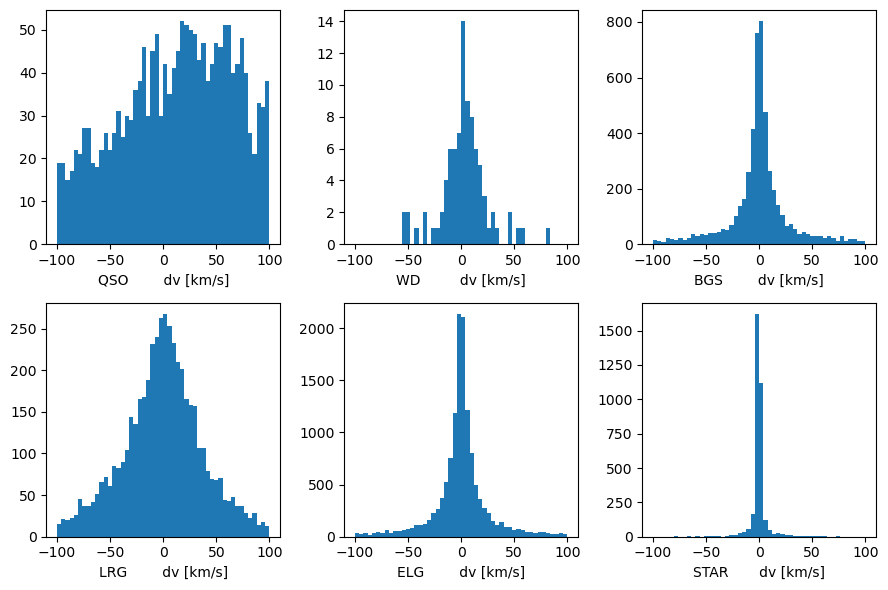

In [14]:
#
# A very similar plot appears in the tutorial notebook dc17a-truth.
#
dv = lightspeed.to('km / s') * np.array([(row.ZCat.z - row.Truth.truez) / (1.0 + row.Truth.truez) for row in q])
ttype = [row.Truth.templatetype for row in q]
fig, axes = plt.subplots(2, 3, figsize=(9,6), dpi=100)
for k, objtype in enumerate(set(ttype)):
    i = k % 2
    j = k % 3
    # s = axes[i].subplot(2, 3, 1+i)
    ii = np.array(ttype) == objtype
    axes[i][j].hist(dv[ii], 50, (-100, 100))
    axes[i][j].set_xlabel('{} dv [km/s]'.format(objtype))
fig.tight_layout()

### Exercise

* For QSOs, plot true redshift versus observed redshift.

## A More Complicated Join

Let's do a consistency check: do the number of observations in the `db.ZCat` table match the corresponding number of exposures and fiber assignments?

In this example, we're using `sqlalchemy.sql.func` to get the equivalent of `COUNT(*)` and a subquery that itself is a multi-table join.

In [15]:
q1 = db.dbSession.query(db.ZCat.targetid, db.FiberAssign.tileid, db.ObsList.expid, func.count('*').label('n_assign'))\
                .filter(db.ZCat.targetid == db.FiberAssign.targetid)\
                .filter(db.FiberAssign.tileid == db.ObsList.tileid)\
                .group_by(db.ZCat.targetid).subquery()
q2 = db.dbSession.query(db.ZCat, q1)\
                 .filter(db.ZCat.targetid == q1.c.targetid)\
                 .order_by(db.ZCat.targetid).all()

In [16]:
#
# Examine the structure of what is returned.
#
q2[0]

(<ZCat(targetid=-229443361)>, -229443361, 45704, 41, 2)

In [17]:
#
# If everything matches up, this should return True.
#
all([row.ZCat.numexp == row.n_assign for row in q2])

True

### Exercise

* What is the distribution of number of exposures?

## Updates

It turns out that the QSO templates in the Truth table are not as useful as they could be.  They should be split into two classes: 'QSO_L' For Lyman-alpha QSOs with redshift >= 2.1 and 'QSO_T' for all other QSOs with redshift < 2.1.

Also note that, currently, strings get loaded into the database with padding, but it's easy to deal with that with a `LIKE` statement.

In [18]:
q = db.dbSession.query(db.Truth).filter(db.Truth.truez >= 2.1).filter(db.Truth.templatetype.like('QSO%')).all()

In [19]:
q[0]

<Truth(targetid=288230398217948825)>

In [20]:
#
# Updates are very easy.
#
for row in q:
    row.templatetype = 'QSO_L'
#
# Commit the changes to the database.
#
db.dbSession.commit()

In [21]:
#
# Did the change happen?
#
q = db.dbSession.query(db.Truth).filter(db.Truth.truez >= 2.1).filter(db.Truth.templatetype.like('QSO%')).all()

In [22]:
all([row.templatetype == 'QSO_L' for row in q])

True

### Exercise

* Do the same for 'QSO_T'.

## Efficiency Studies

In `desisim.spec_qa.redshifts` there is a lot of functionality for matching redshifts to the truth table (file).  This matching is done automatically for us just by doing a join.  Also note that we're letting the database compute the value of `dz`.

We're going to cheat a little bit and convert the database output into an `astropy.table.Table` that can be understood by the `desisim.spec_qa` machinery.  No reason to waste perfectly good code!  In the future, this machinery can & should be updated to use database inputs directly.  Who wants to work on that?

In [23]:
q = db.dbSession.query(db.Truth, db.Target, db.ZCat, ((db.ZCat.z - db.Truth.truez)/(1.0 + db.Truth.truez)).label('dz'))\
                .filter(db.Truth.targetid == db.ZCat.targetid).filter(db.Target.targetid == db.ZCat.targetid).all()

In [24]:
def truth_query_to_table(q):
    """Convert a query result into a Table, so that it can be used with functions in ``desisim.spec_qa.redshifts.``
    """
    t = Table()
    columns = list()
    mask = [False]*len(q)
    for c in db.Truth.__table__.columns:
        if c.name == 'truespectype' or c.name == 'templatetype':
            columns.append(MaskedColumn([np.char.rstrip(getattr(row.Truth, c.name)) for row in q], name=c.name.upper(), mask=mask))
        else:
            columns.append(MaskedColumn([getattr(row.Truth, c.name) for row in q], name=c.name.upper(), mask=mask))
    for c in ('desi_target', 'bgs_target', 'mws_target'):
        columns.append(MaskedColumn([getattr(row.Target, c) for row in q], name=c.upper(), mask=mask))
    for c in ('z', 'zerr', 'zwarn', 'spectype'):
        if c == 'spectype':
            columns.append(MaskedColumn([np.char.rstrip(getattr(row.ZCat, c)) for row in q], name=c.upper(), mask=mask))
        else:
            columns.append(MaskedColumn([getattr(row.ZCat, c) for row in q], name=c.upper(), mask=mask))
    columns.append(MaskedColumn([row.dz for row in q], name='DZ', mask=mask))
    t.add_columns(columns)
    return t
truth = truth_query_to_table(q)

In [25]:
print('          ntarg   good  fail  miss  lost')
for objtype in set(truth['TEMPLATETYPE']):
    #isx = (truth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost, nx = dsq_z.zstats(truth, objtype=objtype)
    #nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
QSO_L       845   99.9   0.1   0.0   0.0
QSO        1959   98.5   0.4   0.7   0.4
LRG        5433  100.0   0.0   0.0   0.0
BGS        3772   92.2   0.2   4.7   3.0
ELG       18095   78.5   0.6   9.1  11.8
STAR       3605   92.3   0.4   1.9   5.4
WD           90  100.0   0.0   0.0   0.0

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


In [26]:
#
# Confusion matrix.  Borrowed from the minitest notebook.
#
confusion = dsq_z.spectype_confusion(truth)
#
# Pretty print the confusion matrix.
#
print('            Redrock')
print('Truth     ', end='')
for s1 in confusion:
    print('{:>8s}'.format(s1), end='')
print()
for s1 in confusion:
    print('{:8s}  '.format(s1), end='')
    for s2 in confusion:
        try:
            print('{:8d}'.format(confusion[s1][s2]), end='')
        except KeyError:
            print('{:8d}'.format(0), end='')
    print()

            Redrock
Truth       GALAXY     QSO    STAR      WD
GALAXY       27514       1       2       0
QSO             14    2790       0       0
STAR           269       0    3336       0
WD               0       0      90       0


In [27]:
#
# Obtain detailed statistics for all objects.
#
stats = dict()
for s in np.unique(truth['TEMPLATETYPE']):
    stats[s] = dsq_z.calc_obj_stats(truth, s)
stats

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


{'BGS': {'N_TARG': 3772,
  'N_zA': 3772,
  'N_SURVEY': 3772,
  'N_CAT': 7,
  'CAT_RATE': 0.001855779427359491,
  'N_GOODZ': 3476,
  'N_ZWARN0': 3483,
  'EFF': 0.9215270413573701,
  'PURITY': 0.9979902383003159,
  'MEAN_DZ': 1.6473930407018026e-06,
  'MEDIAN_DZ': 1.2532100046568876e-06,
  'RMS_DZ': 0.00018535542449003498},
 'ELG': {'N_TARG': 5802,
  'N_zA': 18095,
  'N_SURVEY': 5802,
  'N_CAT': 1,
  'CAT_RATE': 0.0001723543605653223,
  'N_GOODZ': 5769,
  'N_ZWARN0': 5770,
  'EFF': 0.9943123061013444,
  'PURITY': 0.9998266897746967,
  'MEAN_DZ': 1.0178985043626518e-06,
  'MEDIAN_DZ': -4.0334014024321585e-08,
  'RMS_DZ': 5.781933420536454e-05},
 'LRG': {'N_TARG': 5433,
  'N_zA': 5433,
  'N_SURVEY': 5433,
  'N_CAT': 0,
  'CAT_RATE': 0.0,
  'N_GOODZ': 5431,
  'N_ZWARN0': 5431,
  'EFF': 0.9996318792563961,
  'PURITY': 1.0,
  'MEAN_DZ': -3.280541281966512e-06,
  'MEDIAN_DZ': 2.9209981237122196e-07,
  'RMS_DZ': 0.0001788047222669484},
 'QSO': {'N_TARG': 1959,
  'N_zA': 1959,
  'N_SURVEY': 1959

## Going Beyond the Summary

Summary statistics are useful, but they don't tell how efficiency and other parameters depend on each other.  How does efficiency depend on magnitude?  Moon in the sky?

Some capability exists to do this in `desisim.spec_qa.redshifts`, but we'll start with a basic example just to get the feel of plotting.

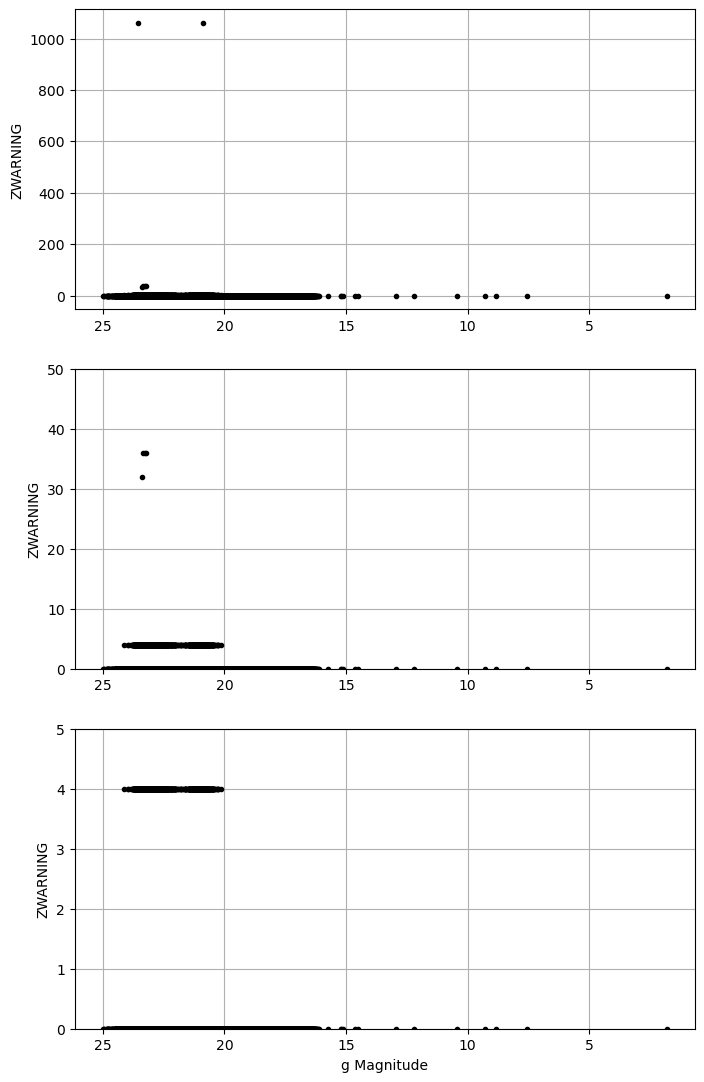

In [28]:
#
# ZWARNING versus magnitude.
#
g = 22.5 - 2.5*np.log10(truth['FLUX_G'])
r = 22.5 - 2.5*np.log10(truth['FLUX_R'])
z = 22.5 - 2.5*np.log10(truth['FLUX_Z'])
fig, axes = plt.subplots(3, 1, figsize=(8, 4.5*3), dpi=100)
p = axes[0].plot(g, truth['ZWARN'], 'k.')
foo = axes[0].set_xlim(axes[0].get_xlim()[1], axes[0].get_xlim()[0])
foo = axes[0].grid(True)
# foo = axes[0].set_xlabel('g Magnitude')
foo = axes[0].set_ylabel('ZWARNING')
p = axes[1].plot(g, truth['ZWARN'], 'k.')
foo = axes[1].set_xlim(axes[1].get_xlim()[1], axes[1].get_xlim()[0])
foo = axes[1].set_ylim(0, 50)
foo = axes[1].grid(True)
# foo = axes[1].set_xlabel('g Magnitude')
foo = axes[1].set_ylabel('ZWARNING')
p = axes[2].plot(g, truth['ZWARN'], 'k.')
foo = axes[2].set_xlim(axes[2].get_xlim()[1], axes[2].get_xlim()[0])
foo = axes[2].set_ylim(0, 5)
foo = axes[2].grid(True)
foo = axes[2].set_xlabel('g Magnitude')
foo = axes[2].set_ylabel('ZWARNING')

`desisim.spec_qa.redshifts.plot_slices()` makes nice plots, so we'll leverage that for a simple example.

In [29]:
#
# Only return a subset of columns, and then use zip() to go from row-based to column-based.
#
q = db.dbSession.query(db.Truth.truez, db.ZCat.z, db.ZCat.zwarn, db.Target.flux_g, 
                       ((db.ZCat.z - db.Truth.truez)/(1.0 + db.Truth.truez)).label('dz'))\
                .filter(db.Truth.targetid == db.ZCat.targetid).filter(db.Target.targetid == db.ZCat.targetid).all()    
truez, z, zwarn, flux_g, dz = zip(*q)
g = 22.5 - 2.5*np.log10(np.array(flux_g))
ok = np.array(zwarn) == 0
dv = lightspeed.to('km / s').value * np.array(dz)
bad = (np.abs(dv) > 1000)

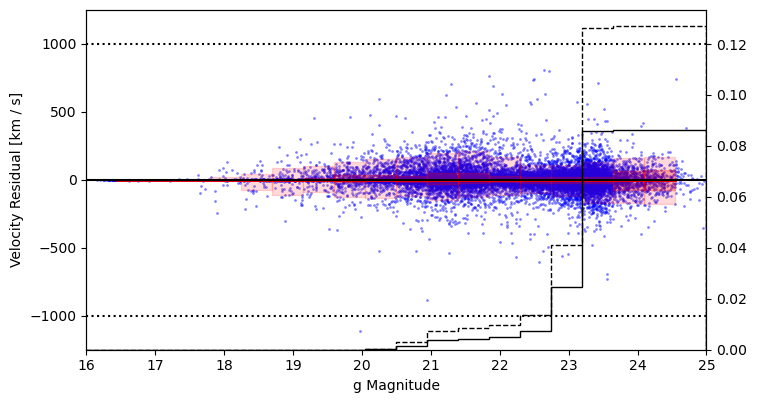

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4.5), dpi=100)
p = dsq_z.plot_slices(g, dv, ok, bad, 16, 25, 1000, num_slices=20, axis=axes)
foo = axes.set_xlabel('g Magnitude')
foo = axes.set_ylabel('Velocity Residual [km / s]')

### Exercises

* Plot a particular template class, *e.g.* 'QSO_T'.
* Plot versus other magnitudes, *e.g.* r, W1.

## Fly me to the Moon

How does the Moon affect redshifts?

In [31]:
#
# How many actual exposures are there with the Moon up?
#
q = db.dbSession.query(db.ObsList.expid, db.ObsList.moonsep, db.ObsList.moonalt, db.ObsList.moonfrac).filter(db.ObsList.moonalt > 0).all()
q

[(8, 122.44709475771212, 0.42488345946132045, 0.4860627058850807),
 (9, 122.53670459889443, 2.3616454543105827, 0.4852787587295292),
 (10, 122.95360969391353, 5.028193277131029, 0.48418123271160535),
 (11, 123.0440276920421, 6.983493291066839, 0.4833611033797137),
 (39, 116.34353638147344, 0.4001825648595744, 0.7545447815726879),
 (40, 116.41446917621921, 1.8375721269357053, 0.7540001078638929),
 (41, 117.19230298558917, 2.965627215753266, 0.7535689078439843),
 (42, 117.25566306308285, 4.2603465939951635, 0.7530696236114574),
 (43, 118.22121418015178, 5.426226448422642, 0.7526157288537715),
 (44, 118.27198428284888, 6.466068399075752, 0.7522072235723536)]

So there are a few.  But there is a subtle issue: redshifts are based on *all* exposures, but maybe there are some redshifts where the object was observed *only* with the Moon up. And we can try to compare those objects to similar objects observed *only* with the Moon down.

In [32]:
expid_up = [x[0] for x in q]
q = db.dbSession.query(db.ZCat.targetid, db.Target.desi_target, db.Target.bgs_target, db.Target.mws_target, db.ObsList.expid)\
                .filter(db.ZCat.targetid == db.FiberAssign.targetid)\
                .filter(db.ZCat.targetid == db.Target.targetid)\
                .filter(db.FiberAssign.tileid == db.ObsList.tileid)\
                .filter(db.ObsList.expid.in_(expid_up))\
                .order_by(db.ZCat.targetid, db.ObsList.expid).all()
targetid, desi_target, bgs_target, mws_target, expid = zip(*q)

In [33]:
sum(['ELG' in desi_mask.names(t) for t in desi_target])

17134

In [34]:
#
# OK, let's find some ELGs with the Moon up, and some with the Moon down.
#
q_up = db.dbSession.query(db.ZCat.targetid, db.Truth.truez, db.ZCat.z, db.ZCat.zwarn,
                       ((db.ZCat.z - db.Truth.truez)/(1.0 + db.Truth.truez)).label('dz'))\
                   .filter(db.Truth.targetid == db.ZCat.targetid)\
                   .filter(db.Target.targetid == db.ZCat.targetid)\
                   .filter(db.ZCat.targetid == db.FiberAssign.targetid)\
                   .filter(db.FiberAssign.tileid == db.ObsList.tileid)\
                   .filter(db.ObsList.expid.in_(expid_up))\
                   .filter(db.Target.desi_target.op('&')(desi_mask.ELG) != 0)\
                   .all()
q_dn = db.dbSession.query(db.ZCat.targetid, db.Truth.truez, db.ZCat.z, db.ZCat.zwarn,
                       ((db.ZCat.z - db.Truth.truez)/(1.0 + db.Truth.truez)).label('dz'))\
                   .filter(db.Truth.targetid == db.ZCat.targetid)\
                   .filter(db.Target.targetid == db.ZCat.targetid)\
                   .filter(db.ZCat.targetid == db.FiberAssign.targetid)\
                   .filter(db.FiberAssign.tileid == db.ObsList.tileid)\
                   .filter(~db.ObsList.expid.in_(expid_up))\
                   .filter(db.Target.desi_target.op('&')(desi_mask.ELG) != 0)\
                   .all()[:8342]
foo, truez_up, z_up, zwarn_up, dz_up = zip(*q_up)
foo, truez_dn, z_dn, zwarn_dn, dz_dn = zip(*q_dn)
truez_up = np.array(truez_up)
z_up = np.array(z_up)
zwarn_up = np.array(zwarn_up)
dv_up = lightspeed.to('km / s').value * np.array(dz_up)
truez_dn = np.array(truez_dn)
z_dn = np.array(z_dn)
zwarn_dn = np.array(zwarn_dn)
dv_dn = lightspeed.to('km / s').value * np.array(dz_dn)
ok_up = zwarn_up == 0
ok_dn = zwarn_dn == 0

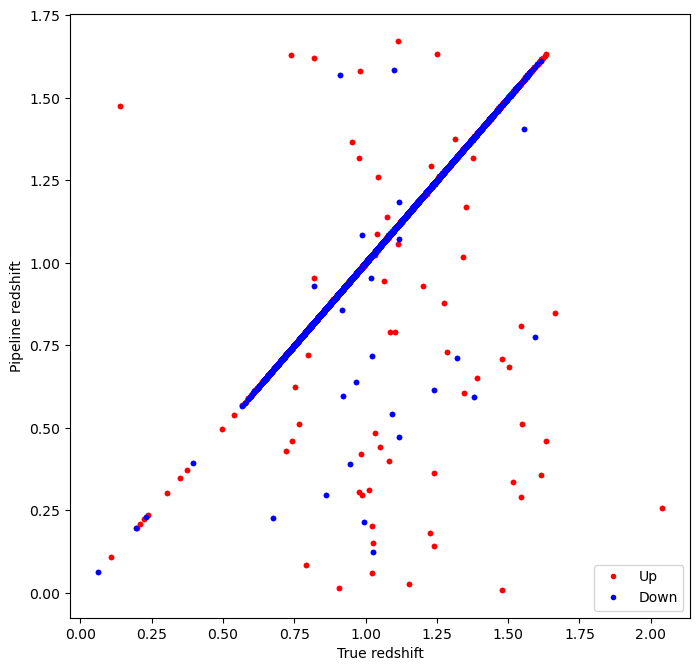

In [35]:
#
# Observed redshift versus true redshift.
#
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
p1 = axes.plot(truez_up[ok_up], z_up[ok_up], 'r.', label='Up')
p2 = axes.plot(truez_dn[ok_dn], z_dn[ok_dn], 'b.', label='Down')
foo = axes.set_xlabel('True redshift')
foo = axes.set_ylabel('Pipeline redshift')
foo = axes.legend(loc=4)

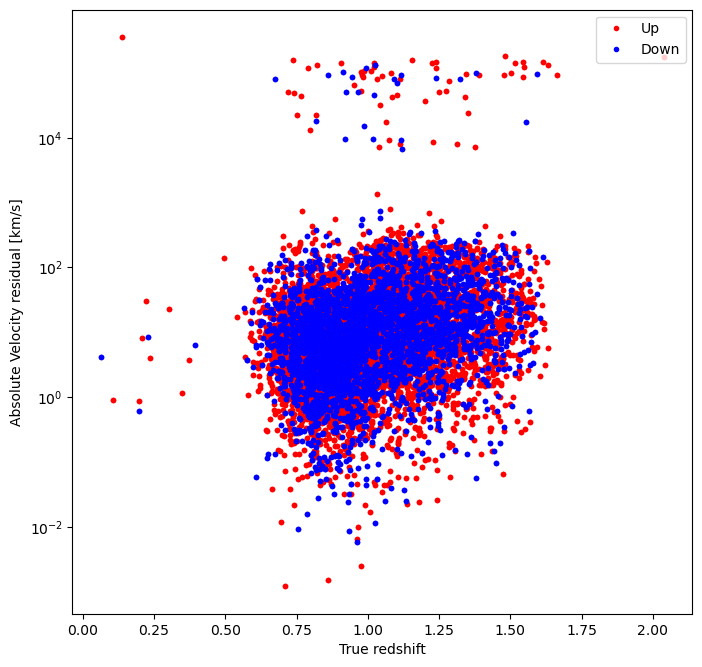

In [36]:
#
# Velocity residual versus true redshift.
#
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
p1 = axes.semilogy(truez_up[ok_up], np.abs(dv_up[ok_up]), 'r.', label='Up')
p2 = axes.semilogy(truez_dn[ok_dn], np.abs(dv_dn[ok_dn]), 'b.', label='Down')
foo = axes.set_xlabel('True redshift')
foo = axes.set_ylabel('Absolute Velocity residual [km/s]')
foo = axes.legend(loc=1)

Well, there doesn't appear to be much difference here.  That's not necessarily a bad thing!

### Exercise

* Try a different target class!

## Survey Progress

Let's see which nights have science data.

In [37]:
q = db.dbSession.query(db.ObsList.night, func.count('*').label('n_science'))\
                .filter(db.ObsList.flavor == 'science')\
                .group_by(db.ObsList.night).order_by(db.ObsList.night).all()
q

[('20200315', 6), ('20200317', 4), ('20200319', 5), ('20200411', 6)]

Observation timestamp for a given night.

In [38]:
q = db.dbSession.query(db.ObsList.expid, db.ObsList.mjd)\
                .filter(db.ObsList.flavor == 'science')\
                .filter(db.ObsList.night == '20200317')\
                .order_by(db.ObsList.mjd).all()
q

[(18, 58926.112499999996),
 (19, 58926.12337962945),
 (20, 58926.13229166635),
 (21, 58926.14074074029)]

So, for a given target in the `target` table, when was the observation completed?  In other words, if a target has multiple observations, we want the date of the *last* observation.

In [39]:
#
# How many targets are there?
#
N_targets = db.dbSession.query(db.Target).count()
N_targets

184540

In [40]:
#
# Find all targetids that have observations.
#
q1 = db.dbSession.query(db.Target.targetid)\
                .filter(db.Target.targetid == db.FiberAssign.targetid)\
                .filter(db.FiberAssign.tileid == db.ObsList.tileid)\
                .group_by(db.Target.targetid)\
                .subquery()
#
# Find the exposure times for the targetids that have been observed
#
q2 = db.dbSession.query(db.FiberAssign.targetid, db.ObsList.expid, db.ObsList.mjd)\
                 .filter(db.FiberAssign.targetid == q1.c.targetid)\
                 .filter(db.FiberAssign.tileid == db.ObsList.tileid)\
                 .order_by(q1.c.targetid, db.ObsList.expid).all()
targetid, expid, mjd = zip(*q2)
targetid = np.array(targetid)
expid = np.array(expid)
mjd = np.array(mjd)
#
# Use the counts to give the *last* observation.
#
unique_targetid, i, j, c = np.unique(targetid, return_index=True, return_inverse=True, return_counts=True)
unique_expid = expid[i + (c-1)]
unique_mjd = mjd[i + (c-1)]

In [41]:
#
# Now we have the targets and the date of last observation.  But it's sorted by targetid.
#
ii = unique_expid.argsort()
unique_targetid, i3, j3, c3 = np.unique(unique_expid[ii], return_index=True, return_inverse=True, return_counts=True)
N_completed = np.cumsum(c3)

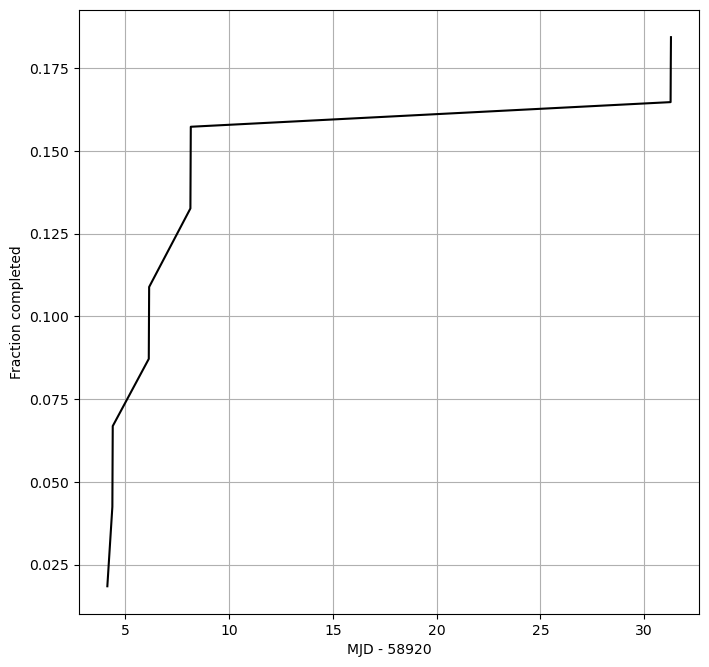

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
p1 = axes.plot(unique_mjd[ii][i3] - 58920, N_completed/N_targets, 'k-')
foo = axes.set_xlabel('MJD - 58920')
foo = axes.set_ylabel('Fraction completed')
foo = axes.grid(True)
# foo = axes.legend(loc=1)

### Exercise

* Break down the progress by target class, target bit, etc.